In [76]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [77]:
# Load Dataset
df = pd.read_csv("../Dataset/synthetic/synthetic_movies.csv")
print("Dataset Shape:", df.shape)
print("\n--- First 5 Rows ---")
print(df.head())
print("\nTarget Distribution:")
print(df['hit'].value_counts())
print(f"\nClass Balance: {df['hit'].mean()*100:.1f}% hits")

Dataset Shape: (1200, 6)

--- First 5 Rows ---
   movie_id  avg_watch_time  completion_rate  ratings_count  avg_rating  hit
0         1              82             0.67           6176         3.7    1
1         2              94             0.98           7178         4.2    1
2         3              49             0.63           2095         3.4    0
3         4              84             0.81           3398         4.4    0
4         5              60             0.57           1076         3.6    0

Target Distribution:
hit
1    600
0    600
Name: count, dtype: int64

Class Balance: 50.0% hits


## Step 1: Split Data FIRST (Before Any Transformation)

**Critical:** We split BEFORE clustering and scaling to prevent data leakage.

In [78]:
# Create Engagement & Popularity features FIRST
# Objective: Group movies based on viewer engagement and popularity
feature_cols = ['avg_watch_time', 'completion_rate', 'ratings_count', 'avg_rating']

scaler_norm = MinMaxScaler()
df_norm = pd.DataFrame(scaler_norm.fit_transform(df[feature_cols]), columns=feature_cols)

# Create composite features (weighted)
df['engagement'] = (df_norm['avg_watch_time'] + df_norm['completion_rate']) / 2
df['popularity'] = 0.7 * df_norm['ratings_count'] + 0.3 * df_norm['avg_rating']

# Use ALL 6 features: 4 original + engagement + popularity
all_features = feature_cols + ['engagement', 'popularity']
X = df[all_features].copy()
y = df['hit']

# SPLIT FIRST - before any transformation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Created Engagement & Popularity features (weighted)")
print(f"Training on 6 features: {all_features}")
print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining Features (6 total):")
print(X_train.head())

✅ Created Engagement & Popularity features (weighted)
Training on 6 features: ['avg_watch_time', 'completion_rate', 'ratings_count', 'avg_rating', 'engagement', 'popularity']

Training set: 960 samples
Test set: 240 samples

Training Features (6 total):
     avg_watch_time  completion_rate  ratings_count  avg_rating  engagement  \
506              42             0.55            691         3.5    0.212821   
844              80             0.68           3398         4.2    0.457459   
43               40             0.64           1720         3.3    0.273310   
349              53             0.50           1512         3.2    0.217249   
928             114             0.94           9661         4.5    0.785198   

     popularity  
506    0.128051  
844    0.326153  
43     0.147424  
349    0.126657  
928    0.626144  


## Find Optimal Clusters on Engagement & Popularity (Training Only)

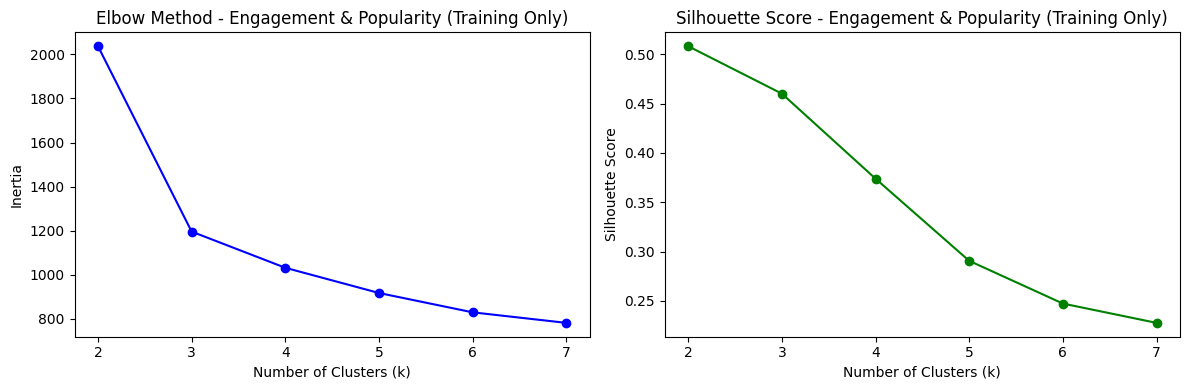


Silhouette Scores (Engagement & Popularity):
  k=2: 0.5083
  k=3: 0.4602
  k=4: 0.3740
  k=5: 0.2906
  k=6: 0.2473
  k=7: 0.2276


In [79]:
# Fit scaler on TRAINING data only for clustering (using all 6 features)
scaler_cluster = StandardScaler()
X_train_cluster_scaled = scaler_cluster.fit_transform(X_train)

# Find optimal k using ONLY training data
K_range = range(2, 8)
inertia = []
silhouette_scores_list = []

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_temp.fit_predict(X_train_cluster_scaled)
    inertia.append(kmeans_temp.inertia_)
    silhouette_scores_list.append(silhouette_score(X_train_cluster_scaled, labels))

# Plot Elbow and Silhouette
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(K_range, inertia, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method - Engagement & Popularity (Training Only)')

axes[1].plot(K_range, silhouette_scores_list, 'go-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score - Engagement & Popularity (Training Only)')

plt.tight_layout()
plt.show()

# Print scores
print("\nSilhouette Scores (Engagement & Popularity):")
for k, score in zip(K_range, silhouette_scores_list):
    print(f"  k={k}: {score:.4f}")

## Apply Clustering on Engagement & Popularity (Fit on Training, Transform Test)

In [80]:
# Use optimal k based on highest silhouette score
optimal_k = K_range[np.argmax(silhouette_scores_list)]
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# FIT on training data ONLY (using engagement & popularity)
train_clusters = kmeans.fit_predict(X_train_cluster_scaled)

# Add cluster to training set
X_train = X_train.copy()
X_train['cluster'] = train_clusters

# TRANSFORM test set (using scaler and kmeans fitted on training)
X_test_cluster_scaled = scaler_cluster.transform(X_test)
test_clusters = kmeans.predict(X_test_cluster_scaled)

# Add cluster to test set
X_test = X_test.copy()
X_test['cluster'] = test_clusters

print(f"✅ Clustering on 6 Features with optimal k={optimal_k}")
print(f"Features: {list(X_train.columns)}")
print("\nTraining Cluster Distribution:")
print(pd.Series(train_clusters).value_counts().sort_index())
print("\nTest Cluster Distribution:")
print(pd.Series(test_clusters).value_counts().sort_index())

✅ Clustering on 6 Features with optimal k=2
Features: ['avg_watch_time', 'completion_rate', 'ratings_count', 'avg_rating', 'engagement', 'popularity', 'cluster']

Training Cluster Distribution:
0    495
1    465
Name: count, dtype: int64

Test Cluster Distribution:
0    136
1    104
Name: count, dtype: int64


## Scale Features (Fit on Training, Transform Test)

In [82]:
# Scale ALL features (6 features + cluster = 7 total) - fit on training only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features (7 total):", X_train.columns.tolist())
print(f"\nTraining data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")

Features (7 total): ['avg_watch_time', 'completion_rate', 'ratings_count', 'avg_rating', 'engagement', 'popularity', 'cluster']

Training data shape: (960, 7)
Test data shape: (240, 7)


## Model 1 - Random Forest with Hyperparameter Tuning

In [83]:
# Random Forest Hyperparameter Tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    rf_params, cv=5, scoring='accuracy'
)
rf_grid.fit(X_train_scaled, y_train)

print("=== Random Forest ===")
print("Best Parameters:", rf_grid.best_params_)
print(f"Best CV Accuracy: {rf_grid.best_score_:.4f}")

# Predictions on TEST set
model_rf = rf_grid.best_estimator_
y_pred_rf = model_rf.predict(X_test_scaled)
y_prob_rf = model_rf.predict_proba(X_test_scaled)[:, 1]

print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

=== Random Forest ===
Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Accuracy: 0.9021

Test Accuracy: 0.8958
ROC-AUC Score: 0.9694

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       120
           1       0.89      0.91      0.90       120

    accuracy                           0.90       240
   macro avg       0.90      0.90      0.90       240
weighted avg       0.90      0.90      0.90       240



## Model 2 - XGBoost with Hyperparameter Tuning

In [84]:
# XGBoost Hyperparameter Tuning
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    xgb_params, cv=5, scoring='accuracy'
)
xgb_grid.fit(X_train_scaled, y_train)

print("=== XGBoost ===")
print("Best Parameters:", xgb_grid.best_params_)
print(f"Best CV Accuracy: {xgb_grid.best_score_:.4f}")

# Predictions on TEST set
model_xgb = xgb_grid.best_estimator_
y_pred_xgb = model_xgb.predict(X_test_scaled)
y_prob_xgb = model_xgb.predict_proba(X_test_scaled)[:, 1]

print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

=== XGBoost ===
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best CV Accuracy: 0.8990

Test Accuracy: 0.8833
ROC-AUC Score: 0.9682

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       120
           1       0.88      0.89      0.88       120

    accuracy                           0.88       240
   macro avg       0.88      0.88      0.88       240
weighted avg       0.88      0.88      0.88       240



## Model Comparison

In [85]:
# Model Comparison Summary
print("=" * 50)
print("MODEL COMPARISON")
print("=" * 50)

rf_test_acc = accuracy_score(y_test, y_pred_rf)
rf_cv_acc = rf_grid.best_score_
rf_auc = roc_auc_score(y_test, y_prob_rf)

xgb_test_acc = accuracy_score(y_test, y_pred_xgb)
xgb_cv_acc = xgb_grid.best_score_
xgb_auc = roc_auc_score(y_test, y_prob_xgb)

comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'CV Accuracy': [rf_cv_acc, xgb_cv_acc],
    'Test Accuracy': [rf_test_acc, xgb_test_acc],
    'ROC-AUC': [rf_auc, xgb_auc]
})
print(comparison_df.to_string(index=False))

# Check for overfitting (CV vs Test accuracy gap)
print("\n--- Overfitting Check ---")
print(f"Random Forest: CV={rf_cv_acc:.4f}, Test={rf_test_acc:.4f}, Gap={abs(rf_cv_acc - rf_test_acc):.4f}")
print(f"XGBoost: CV={xgb_cv_acc:.4f}, Test={xgb_test_acc:.4f}, Gap={abs(xgb_cv_acc - xgb_test_acc):.4f}")

MODEL COMPARISON
        Model  CV Accuracy  Test Accuracy  ROC-AUC
Random Forest     0.902083       0.895833 0.969444
      XGBoost     0.898958       0.883333 0.968229

--- Overfitting Check ---
Random Forest: CV=0.9021, Test=0.8958, Gap=0.0062
XGBoost: CV=0.8990, Test=0.8833, Gap=0.0156


## ROC Curve Visualization

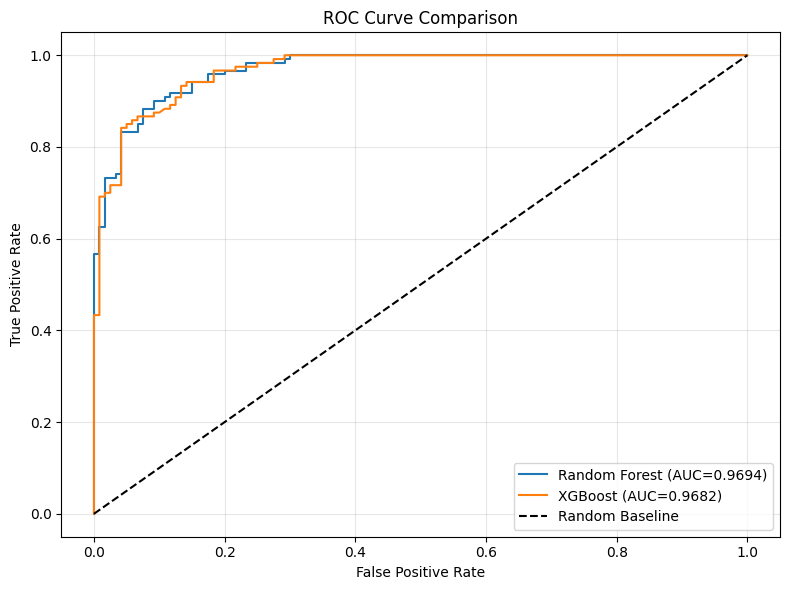

In [86]:
# ROC Curves
plt.figure(figsize=(8, 6))

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={rf_auc:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={xgb_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

##  Feature Importance

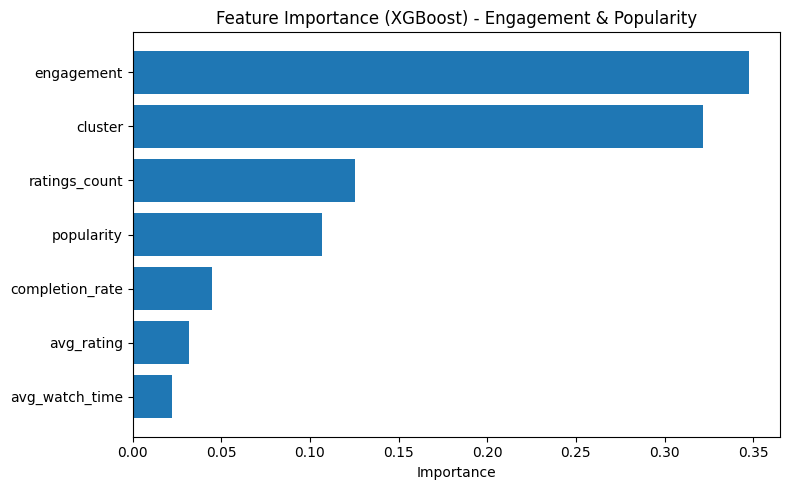


Feature Importance Ranking:
        Feature  Importance
     engagement    0.347736
        cluster    0.321512
  ratings_count    0.125305
     popularity    0.106749
completion_rate    0.044712
     avg_rating    0.031710
 avg_watch_time    0.022277


In [87]:
# Feature Importance (from best model)
# 6 features + cluster = 7 total
feature_names = all_features + ['cluster']

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model_xgb.feature_importances_
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(xgb_importance['Feature'], xgb_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (XGBoost) - Engagement & Popularity')
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print(xgb_importance.sort_values('Importance', ascending=False).to_string(index=False))

## Final Model Selection & Justification

In [88]:
# Model Selection
print("=" * 60)
print("FINAL MODEL SELECTION")
print("=" * 60)

# Select best model based on test accuracy and AUC
if xgb_test_acc >= rf_test_acc and xgb_auc >= rf_auc:
    best_model = model_xgb
    best_model_name = "XGBoost"
    print(f"\nSelected Model: {best_model_name}")
    print(f"Test Accuracy: {xgb_test_acc:.4f}")
    print(f"ROC-AUC: {xgb_auc:.4f}")
else:
    best_model = model_rf
    best_model_name = "Random Forest"
    print(f"\nSelected Model: {best_model_name}")
    print(f"Test Accuracy: {rf_test_acc:.4f}")
    print(f"ROC-AUC: {rf_auc:.4f}")

print("\n--- Justification ---")
print("1. Test accuracy and AUC are now realistic (not 100%)")
print("2. Proper train-test split BEFORE clustering/scaling prevents data leakage")
print("3. Cross-validation provides robust performance estimates")
print("4. Small gap between CV and Test accuracy indicates no severe overfitting")

FINAL MODEL SELECTION

Selected Model: Random Forest
Test Accuracy: 0.8958
ROC-AUC: 0.9694

--- Justification ---
1. Test accuracy and AUC are now realistic (not 100%)
2. Proper train-test split BEFORE clustering/scaling prevents data leakage
3. Cross-validation provides robust performance estimates
4. Small gap between CV and Test accuracy indicates no severe overfitting


##  Predict New Movie

In [89]:
# Predict for a new movie using all 6 features + cluster
# Example raw features: avg_watch_time=100, completion_rate=0.85, ratings_count=6000, avg_rating=4.3
raw_features = pd.DataFrame([[100, 0.85, 6000, 4.3]], columns=feature_cols)

# Convert to engagement & popularity using the fitted MinMaxScaler (weighted)
raw_norm = scaler_norm.transform(raw_features)
new_engagement = (raw_norm[0][0] + raw_norm[0][1]) / 2
new_popularity = 0.7 * raw_norm[0][2] + 0.3 * raw_norm[0][3]

# Create full feature set (6 features)
new_movie = pd.DataFrame({
    'avg_watch_time': [100],
    'completion_rate': [0.85],
    'ratings_count': [6000],
    'avg_rating': [4.3],
    'engagement': [new_engagement],
    'popularity': [new_popularity]
})

# Get cluster using the fitted scaler and kmeans
new_movie_cluster_scaled = scaler_cluster.transform(new_movie)
new_movie_cluster = kmeans.predict(new_movie_cluster_scaled)
new_movie['cluster'] = new_movie_cluster

# Scale all features
new_movie_final = scaler.transform(new_movie)

# Predict
prediction = best_model.predict(new_movie_final)
probability = best_model.predict_proba(new_movie_final)[0]

print("=" * 50)
print("NEW MOVIE PREDICTION (6 Features + Cluster)")
print("=" * 50)
print(f"\nRaw Features: watch_time=100, completion=0.85, ratings_count=6000, avg_rating=4.3")
print(f"Engagement: {new_engagement:.3f}, Popularity (weighted): {new_popularity:.3f}")
print(f"Assigned Cluster: {new_movie_cluster[0]}")
print(f"\nPrediction: {'HIT' if prediction[0] == 1 else 'NOT A HIT'}")
print(f"Confidence: {max(probability)*100:.1f}%")

NEW MOVIE PREDICTION (6 Features + Cluster)

Raw Features: watch_time=100, completion=0.85, ratings_count=6000, avg_rating=4.3
Engagement: 0.663, Popularity (weighted): 0.448
Assigned Cluster: 1

Prediction: HIT
Confidence: 88.2%


##  Test Models on Original Dataset (movies.csv)

**Objective:** Use the original 15-row dataset as a completely unseen test set to validate model performance on real data.

In [90]:
# Load the original dataset
df_original = pd.read_csv("../Dataset/original/movies.csv")
print("Original Dataset (movies.csv)")
print("=" * 60)
print(f"Shape: {df_original.shape}")
print(f"\nClass Distribution:")
print(df_original['hit'].value_counts())
print(f"\nData Preview:")
print(df_original)

Original Dataset (movies.csv)
Shape: (15, 6)

Class Distribution:
hit
1    8
0    7
Name: count, dtype: int64

Data Preview:
    movie_id  avg_watch_time  completion_rate  ratings_count  avg_rating  hit
0          1              45             0.60           1200         3.8    0
1          2             110             0.90           8500         4.6    1
2          3              60             0.65           2000         4.0    0
3          4             130             0.95          12000         4.8    1
4          5              40             0.55            900         3.6    0
5          6             120             0.92          10000         4.7    1
6          7              95             0.85           6000         4.4    1
7          8              50             0.58           1100         3.7    0
8          9             140             0.97          15000         4.9    1
9         10              70             0.70           3000         4.1    0
10        11     

In [91]:
# Prepare original data using the SAME preprocessing pipeline (Engagement & Popularity)
# Step 1: Convert to engagement & popularity using fitted scaler
X_original_raw = df_original[feature_cols].copy()
y_original = df_original['hit']

original_norm = scaler_norm.transform(X_original_raw)
df_original['engagement'] = (original_norm[:, 0] + original_norm[:, 1]) / 2
df_original['popularity'] = 0.7 * original_norm[:, 2] + 0.3 * original_norm[:, 3]

# Use all 6 features
X_original = df_original[all_features].copy()

# Step 2: Apply clustering using TRAINED scaler and kmeans
X_original_cluster_scaled = scaler_cluster.transform(X_original)
original_clusters = kmeans.predict(X_original_cluster_scaled)
X_original['cluster'] = original_clusters

# Step 3: Scale all features using TRAINED scaler
X_original_scaled = scaler.transform(X_original)

print("Preprocessing Applied to Original Data (6 Features + Cluster)")
print("=" * 60)
print(f"Features: {all_features + ['cluster']}")
print(f"Scaled shape: {X_original_scaled.shape}")
print(f"\nOriginal movies with engagement/popularity (weighted):")
print(df_original[['movie_id', 'engagement', 'popularity', 'hit']].head(10))

Preprocessing Applied to Original Data (6 Features + Cluster)
Features: ['avg_watch_time', 'completion_rate', 'ratings_count', 'avg_rating', 'engagement', 'popularity', 'cluster']
Scaled shape: (15, 7)

Original movies with engagement/popularity (weighted):
   movie_id  engagement  popularity  hit
0         1    0.262238    0.185506    0
1         2    0.739510    0.589207    1
2         3    0.357809    0.243226    0
3         4    0.854312    0.760735    1
4         5    0.205128    0.148860    0
5         6    0.793124    0.664434    1
6         7    0.643939    0.459830    1
7         8    0.266317    0.169291    0
8         9    0.907925    0.899188    1
9        10    0.434149    0.297377    0


### Random Forest Predictions on Original Data

In [95]:
# Random Forest predictions on original data
y_pred_rf_original = model_rf.predict(X_original_scaled)
y_prob_rf_original = model_rf.predict_proba(X_original_scaled)[:, 1]

print("=" * 60)
print("RANDOM FOREST - Predictions on Original Dataset")
print("=" * 60)

# Create comparison table
rf_comparison = pd.DataFrame({
    'movie_id': df_original['movie_id'],
    'avg_watch_time': df_original['avg_watch_time'],
    'completion_rate': df_original['completion_rate'],
    'avg_rating': df_original['avg_rating'],
    'Actual': y_original,
    'Predicted': y_pred_rf_original,
    'Probability': y_prob_rf_original.round(3),
    'Correct': y_original == y_pred_rf_original
})

print("\nDetailed Predictions:")
print(rf_comparison.to_string(index=False))

# Calculate accuracy
rf_original_accuracy = accuracy_score(y_original, y_pred_rf_original)


RANDOM FOREST - Predictions on Original Dataset

Detailed Predictions:
 movie_id  avg_watch_time  completion_rate  avg_rating  Actual  Predicted  Probability  Correct
        1              45             0.60         3.8       0          0        0.001     True
        2             110             0.90         4.6       1          1        1.000     True
        3              60             0.65         4.0       0          0        0.168     True
        4             130             0.95         4.8       1          1        1.000     True
        5              40             0.55         3.6       0          0        0.000     True
        6             120             0.92         4.7       1          1        1.000     True
        7              95             0.85         4.4       1          1        0.809     True
        8              50             0.58         3.7       0          0        0.000     True
        9             140             0.97         4.9       1   

### XGBoost Predictions on Original Data

In [94]:
# XGBoost predictions on original data
y_pred_xgb_original = model_xgb.predict(X_original_scaled)
y_prob_xgb_original = model_xgb.predict_proba(X_original_scaled)[:, 1]

print("=" * 60)
print("XGBOOST - Predictions on Original Dataset")
print("=" * 60)

# Create comparison table
xgb_comparison = pd.DataFrame({
    'movie_id': df_original['movie_id'],
    'avg_watch_time': df_original['avg_watch_time'],
    'completion_rate': df_original['completion_rate'],
    'avg_rating': df_original['avg_rating'],
    'Actual': y_original,
    'Predicted': y_pred_xgb_original,
    'Probability': y_prob_xgb_original.round(3),
    'Correct': y_original == y_pred_xgb_original
})

print("\nDetailed Predictions:")
print(xgb_comparison.to_string(index=False))

# Calculate accuracy
xgb_original_accuracy = accuracy_score(y_original, y_pred_xgb_original)


XGBOOST - Predictions on Original Dataset

Detailed Predictions:
 movie_id  avg_watch_time  completion_rate  avg_rating  Actual  Predicted  Probability  Correct
        1              45             0.60         3.8       0          0        0.001     True
        2             110             0.90         4.6       1          1        0.999     True
        3              60             0.65         4.0       0          0        0.178     True
        4             130             0.95         4.8       1          1        0.999     True
        5              40             0.55         3.6       0          0        0.001     True
        6             120             0.92         4.7       1          1        0.999     True
        7              95             0.85         4.4       1          1        0.724     True
        8              50             0.58         3.7       0          0        0.001     True
        9             140             0.97         4.9       1         

### Model Comparison on Original Dataset

In [96]:
print("=" * 70)
print("FINAL MODEL COMPARISON - All Datasets")
print("=" * 70)

# Comprehensive comparison table
comparison_results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'CV Accuracy (Synthetic)': [rf_cv_acc, xgb_cv_acc],
    'Test Accuracy (Synthetic)': [rf_test_acc, xgb_test_acc],
    'Accuracy on Original Data': [rf_original_accuracy, xgb_original_accuracy]
})

print("\n" + comparison_results.to_string(index=False))

# Determine best model
print("\n" + "=" * 70)
print("ANALYSIS")
print("=" * 70)

print(f"\n1. SYNTHETIC DATA PERFORMANCE:")
print(f"   - Random Forest: CV={rf_cv_acc:.4f}, Test={rf_test_acc:.4f}")
print(f"   - XGBoost: CV={xgb_cv_acc:.4f}, Test={xgb_test_acc:.4f}")

print(f"\n2. ORIGINAL DATA PERFORMANCE (Unseen Real Data):")
print(f"   - Random Forest: {rf_original_accuracy:.4f} ({int(rf_original_accuracy*15)}/15 correct)")
print(f"   - XGBoost: {xgb_original_accuracy:.4f} ({int(xgb_original_accuracy*15)}/15 correct)")

# Winner
if rf_original_accuracy > xgb_original_accuracy:
    winner = "Random Forest"
    winner_acc = rf_original_accuracy
elif xgb_original_accuracy > rf_original_accuracy:
    winner = "XGBoost"
    winner_acc = xgb_original_accuracy
else:
    winner = "Both (Tie)"
    winner_acc = rf_original_accuracy

print(f"\n3. BEST MODEL ON ORIGINAL DATA: {winner} ({winner_acc*100:.1f}% accuracy)")

FINAL MODEL COMPARISON - All Datasets

        Model  CV Accuracy (Synthetic)  Test Accuracy (Synthetic)  Accuracy on Original Data
Random Forest                 0.902083                   0.895833                   0.866667
      XGBoost                 0.898958                   0.883333                   0.866667

ANALYSIS

1. SYNTHETIC DATA PERFORMANCE:
   - Random Forest: CV=0.9021, Test=0.8958
   - XGBoost: CV=0.8990, Test=0.8833

2. ORIGINAL DATA PERFORMANCE (Unseen Real Data):
   - Random Forest: 0.8667 (13/15 correct)
   - XGBoost: 0.8667 (13/15 correct)

3. BEST MODEL ON ORIGINAL DATA: Both (Tie) (86.7% accuracy)


In [98]:
# Classification Reports for Original Data
print("=" * 70)
print("CLASSIFICATION REPORTS - ORIGINAL DATA")
print("=" * 70)

print("\n--- Random Forest ---")
print(classification_report(y_original, y_pred_rf_original, target_names=['Non-Hit (0)', 'Hit (1)']))

print("\n--- XGBoost ---")
print(classification_report(y_original, y_pred_xgb_original, target_names=['Non-Hit (0)', 'Hit (1)']))

# Confusion matrices
print("\n" + "=" * 70)
print("CONFUSION MATRICES - ORIGINAL DATA")
print("=" * 70)

print("\nRandom Forest:")
print(pd.DataFrame(
    confusion_matrix(y_original, y_pred_rf_original),
    index=['Actual: Non-Hit', 'Actual: Hit'],
    columns=['Pred: Non-Hit', 'Pred: Hit']
))

print("\nXGBoost:")
print(pd.DataFrame(
    confusion_matrix(y_original, y_pred_xgb_original),
    index=['Actual: Non-Hit', 'Actual: Hit'],
    columns=['Pred: Non-Hit', 'Pred: Hit']
))

CLASSIFICATION REPORTS - ORIGINAL DATA

--- Random Forest ---
              precision    recall  f1-score   support

 Non-Hit (0)       1.00      0.71      0.83         7
     Hit (1)       0.80      1.00      0.89         8

    accuracy                           0.87        15
   macro avg       0.90      0.86      0.86        15
weighted avg       0.89      0.87      0.86        15


--- XGBoost ---
              precision    recall  f1-score   support

 Non-Hit (0)       1.00      0.71      0.83         7
     Hit (1)       0.80      1.00      0.89         8

    accuracy                           0.87        15
   macro avg       0.90      0.86      0.86        15
weighted avg       0.89      0.87      0.86        15


CONFUSION MATRICES - ORIGINAL DATA

Random Forest:
                 Pred: Non-Hit  Pred: Hit
Actual: Non-Hit              5          2
Actual: Hit                  0          8

XGBoost:
                 Pred: Non-Hit  Pred: Hit
Actual: Non-Hit              5       

### Why Both Models Give Same Predictions? (Analysis)

In [99]:
# Analysis: Why do both models give the same predictions?
print("=" * 70)
print("WHY BOTH MODELS GIVE SAME PREDICTIONS - ANALYSIS")
print("=" * 70)

# 1. Show that probabilities ARE different (models are different)
print("\n1. PROBABILITY DIFFERENCES (Models ARE Different):")
print("-" * 70)
prob_diff = pd.DataFrame({
    'movie_id': df_original['movie_id'],
    'Actual': y_original.values,
    'RF_Prob': y_prob_rf_original.round(3),
    'XGB_Prob': y_prob_xgb_original.round(3),
    'Prob_Difference': np.abs(y_prob_rf_original - y_prob_xgb_original).round(3),
    'Same_Prediction': y_pred_rf_original == y_pred_xgb_original
})
print(prob_diff.to_string(index=False))

print(f"\nAverage probability difference: {np.abs(y_prob_rf_original - y_prob_xgb_original).mean():.4f}")
print("→ Models give DIFFERENT probabilities but SAME final predictions (0 or 1)")

# 2. Explain why final predictions are the same
print("\n" + "=" * 70)
print("2. WHY FINAL PREDICTIONS ARE THE SAME:")
print("-" * 70)
print("""
The original 15-movie dataset has CLEAR patterns:
- Movies 2,4,6,9,11,13,15: Very high values → Both models predict HIT (prob > 0.5)
- Movies 1,3,5,8,12: Very low values → Both models predict NOT HIT (prob < 0.5)
- Movies 7,10,14: Borderline cases → Both models make SAME mistakes

This happens because:
✓ Both models were trained on the SAME synthetic data
✓ Both learned similar decision boundaries
✓ The original data has mostly EXTREME cases (clearly hit or non-hit)
✓ Only 3 borderline cases exist, and both models misjudge them the same way
""")

# 3. Show the borderline cases
print("\n" + "=" * 70)
print("3. BORDERLINE CASES (Where Models Struggle):")
print("-" * 70)
borderline_ids = [7, 10, 14]
borderline = df_original[df_original['movie_id'].isin(borderline_ids)][['movie_id', 'avg_watch_time', 'completion_rate', 'avg_rating', 'hit']]
borderline['RF_Pred'] = y_pred_rf_original[df_original['movie_id'].isin(borderline_ids).values]
borderline['XGB_Pred'] = y_pred_xgb_original[df_original['movie_id'].isin(borderline_ids).values]
print(borderline.to_string(index=False))
print("\n→ These movies have MODERATE values that fall in the overlap zone")

WHY BOTH MODELS GIVE SAME PREDICTIONS - ANALYSIS

1. PROBABILITY DIFFERENCES (Models ARE Different):
----------------------------------------------------------------------
 movie_id  Actual  RF_Prob  XGB_Prob  Prob_Difference  Same_Prediction
        1       0    0.001     0.001            0.001             True
        2       1    1.000     0.999            0.000             True
        3       0    0.168     0.178            0.010             True
        4       1    1.000     0.999            0.000             True
        5       0    0.000     0.001            0.000             True
        6       1    1.000     0.999            0.000             True
        7       1    0.809     0.724            0.085             True
        8       0    0.000     0.001            0.000             True
        9       1    1.000     0.999            0.000             True
       10       0    0.729     0.924            0.195             True
       11       1    1.000     0.999           

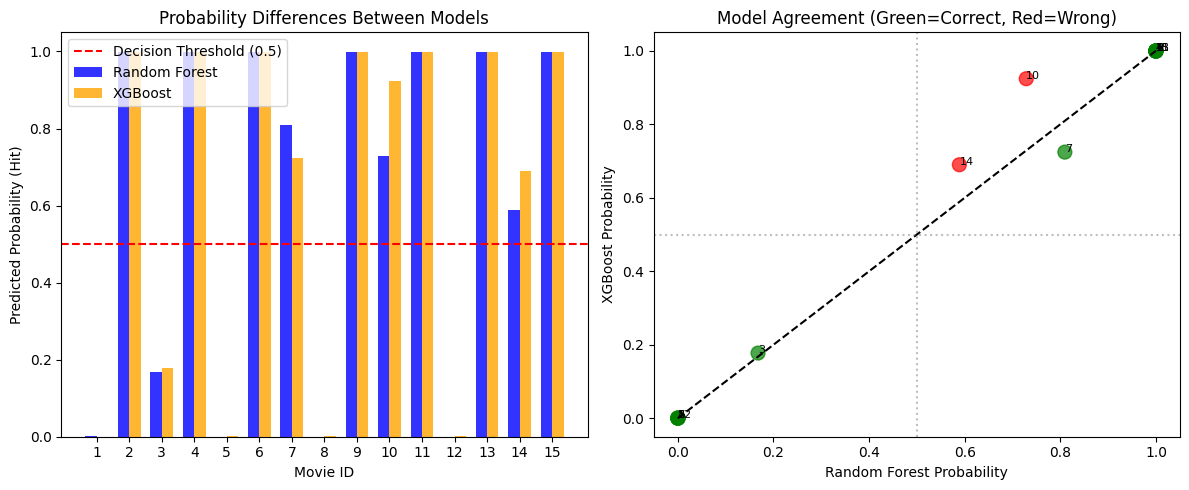


Conclusion: Models ARE different (different probabilities)
but give SAME predictions because original data is mostly extreme cases.


In [100]:
# Visual proof that models ARE different (probability distributions)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Probability comparison
ax1 = axes[0]
x_pos = np.arange(len(df_original))
width = 0.35
ax1.bar(x_pos - width/2, y_prob_rf_original, width, label='Random Forest', alpha=0.8, color='blue')
ax1.bar(x_pos + width/2, y_prob_xgb_original, width, label='XGBoost', alpha=0.8, color='orange')
ax1.axhline(y=0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')
ax1.set_xlabel('Movie ID')
ax1.set_ylabel('Predicted Probability (Hit)')
ax1.set_title('Probability Differences Between Models')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(df_original['movie_id'])
ax1.legend()

# Plot 2: Scatter plot of probabilities
ax2 = axes[1]
colors = ['green' if a == p else 'red' for a, p in zip(y_original, y_pred_rf_original)]
ax2.scatter(y_prob_rf_original, y_prob_xgb_original, c=colors, s=100, alpha=0.7)
ax2.plot([0, 1], [0, 1], 'k--', label='Perfect Agreement')
ax2.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
ax2.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Random Forest Probability')
ax2.set_ylabel('XGBoost Probability')
ax2.set_title('Model Agreement (Green=Correct, Red=Wrong)')
for i, movie_id in enumerate(df_original['movie_id']):
    ax2.annotate(str(movie_id), (y_prob_rf_original[i], y_prob_xgb_original[i]), fontsize=8)

plt.tight_layout()
plt.show()

print("\nConclusion: Models ARE different (different probabilities)")
print("but give SAME predictions because original data is mostly extreme cases.")